# W maze demo

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import struct

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

# assume default aesthetics
npl.setup()

%matplotlib inline

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [2]:
import scipy.io

datadir = 'G:/Single_Day_WTrack/KL8_direct/'
mat = scipy.io.loadmat(datadir + 'KL8spikes01.mat', 
                       struct_as_record=False, squeeze_me=False)


In [3]:
e = 1
t = 1
c = 1
mat['spikes'][0][0][0][e][0][t][0][c].size

0

In [4]:
def load_spike(mat) :
    spikedata = []
    spiketimes = {}
    timeranges = {}
    # Spike files contain data for all epochs, tetrodes, and cells in a day
    # Some epochs have fields: ['data', 'descript', 'fields', 'depth', 'spikewidth', 'timerange']
    # but some epochs are missing 'spikewidth'
    data = mat['spikes'][0][0][0]
    for epidx, da in enumerate(data):
        for tetidx, te in enumerate(da[0]):
            if isinstance(te[0], np.ndarray) :
                for cellidx, cell in enumerate(te[0]):
                    spikedata.append({})
                    spikedata[-1]['Epoch'] = epidx
                    neuron_idx = (tetidx, cellidx)
                    
                    if (tetidx, cellidx) not in spiketimes:
                        spiketimes[(tetidx, cellidx)] = []
                        timeranges[(tetidx, cellidx)] = []
                    spikedata[-1]['Tetrode'] = tetidx
                    spikedata[-1]['Cell'] = cellidx                    
                    if (cell.size == 0):
                        # print(neuron_idx, ': no data')
                        continue # No data for this tetrode/cell combo

                    cell00 = cell[0][0]                    
                        
                    timeranges[(tetidx,cellidx)].append(cell00.timerange)

                    spikedata[-1].update({f: getattr(cell00,f) for f in cell00._fieldnames})
                    
                    if cell00.data.size == 0 :
                        spikedata[-1]['spiketimes'] = cell00.data # this is an empty array
                    else :
                        if (cell.data.ndim == 1) :
                            spikedata[-1]['spiketimes'] = cell00.data[0]
                            spiketimes[(tetidx,cellidx)].extend(cell00.data[0])
                        else :
                            spikedata[-1]['spiketimes'] = cell00.data[:,0]
                            spiketimes[(tetidx,cellidx)].extend(cell00.data[:,0])


    return spikedata, spiketimes, timeranges


In [5]:
spikedata, spiketimes, timeranges = load_spike(mat)

In [6]:
#Gets rid of entries in data that have no data
spikes = []
for dat in spikedata:
    spikedata_cell = dat
    if  len(spikedata_cell) > 3:
        spikes.append({})
        spikes[-1] = spikedata_cell
        del spikedata_cell
    else:
        del spikedata_cell
        continue

# Make an Epoch Array of the session data

In [7]:
session_bounds = nel.EpochArray(timeranges[(3,0)]) 
print(session_bounds)

<EpochArray at 0x1263c198: 17 epochs> of length 5:50:03:515 hours


# Convert spike times to a SpikeTrainArray

In [8]:
stlist = []
for s in spiketimes.values():
    stlist.append(np.array(s))

st = nel.SpikeTrainArray(timestamps=stlist, support=session_bounds, fs=30000)
st.support

<EpochArray at 0x1263c198: 17 epochs> of length 5:50:03:515 hours

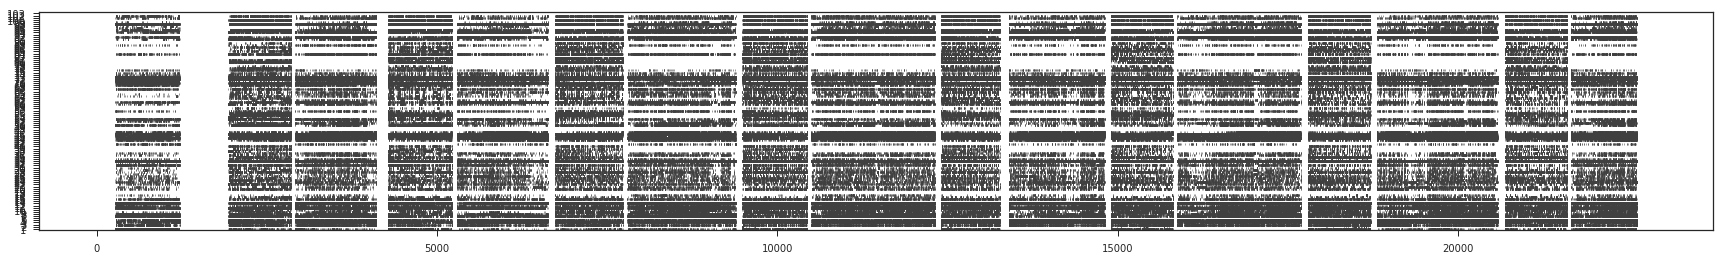

In [9]:
with npl.FigureManager(show=True, figsize=(30,4)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.rasterplot(st, lw=0.5, ax=ax)


# Load Cell Identities - JS

In [10]:
# specify tetrodes in hpc and pfc
#epochlist = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
#ca1tet = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25] #JS15
#pfctet = [0, 1, 2, 3, 14, 15, 16, 17, 18, 19, 27, 28, 29, 30, 31]  #JS15
ca1tet = [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26] #KL8
pfctet = [1, 2, 3, 4, 5, 6, 17, 18, 19, 20, 27, 28, 29, 30, 31, 32] #KL8
#pfctet = [0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 26, 28, 29, 30, 31]; #ER1

ca1_spikes = []
for tet in ca1tet:
    for t, cell in enumerate(spikes):
        if cell['Tetrode'] == tet:
            cell['Area'] = 'CA1'
            if 'meanrate' in cell:
                if cell['meanrate'] > 7:
                    cell['tag'] = 'CA1int'
                    ca1_spikes.append({})
                    ca1_spikes[-1] = cell
                    spikes[t]['tag'] = 'CA1int'
                    spikes[t]['Area'] = 'CA1'
                else:
                    cell['tag'] = 'CA1pyr'
                    ca1_spikes.append({})
                    ca1_spikes[-1] = cell 
                    spikes[t]['tag'] = 'CA1pyr'
                    spikes[t]['Area'] = 'CA1'
        else:
            continue
        
pfc_spikes = []
for tet2 in pfctet:
    for t, cell in enumerate(spikes):
        if cell['Tetrode'] == tet2:
            cell['Area'] = 'PFC'
            pfc_spikes.append({})
            pfc_spikes[-1] = cell
            spikes[t]['Area'] = 'PFC'
        else:
            continue

matchidx = []
for x in ca1_spikes:
    if x['Epoch'] == 1:
        cell = x['Cell']
        tet = x['Tetrode'] 
        matchidx.append({})
        matchidx[-1]['Cell'] = cell
        matchidx[-1]['Tetrode'] = tet

cellidx=[]        
for match in matchidx:
    c = match['Cell']
    t = match['Tetrode']
    idx = [t, c]
    cellidx.append(idx)
    cellidx.sort()
    
eparray = [1]  
allep_cellidx = []
for ep in eparray: 
    for c in cellidx:
        cellinep_count = []
        for sp in ca1_spikes:
            if sp['Tetrode'] == c[0] and sp['Cell'] == c[1] and sp['Epoch'] % 2 == 1 and sp['tag'] == 'CA1pyr' and sp['Area'] == 'CA1': #get run sessions
                cellinep_count.append(sp)
        if len(cellinep_count) == 8: #dirty way to specify number of epochs to match over
            allep_cellidx.append(c)
            
hpidx = allep_cellidx     

del allep_cellidx
        
matchidx = []
for x in pfc_spikes:
    if x['Epoch'] == 1:
        cell = x['Cell']
        tet = x['Tetrode'] 
        matchidx.append({})
        matchidx[-1]['Cell'] = cell
        matchidx[-1]['Tetrode'] = tet

cellidx=[]        
for match in matchidx:
    c = match['Cell']
    t = match['Tetrode']
    idx = [t, c]
    cellidx.append(idx)
    cellidx.sort()
    
eparray = [1]  
allep_cellidx = []
for ep in eparray: 
    for c in cellidx:
        cellinep_count = []
        for sp in pfc_spikes:
            if sp['Tetrode'] == c[0] and sp['Cell'] == c[1] and sp['Epoch'] % 2 == 1 and sp['Area'] == 'PFC': #get run sessions
                cellinep_count.append(sp)
        if len(cellinep_count) == 8: #dirty way to specify number of epochs to match over
            allep_cellidx.append(c)
            
ctxidx = allep_cellidx

print(len(hpidx), " hippocampal pyramidals")
print(len(ctxidx), " PFC neurons")

48  hippocampal pyramidals
30  PFC neurons


In [11]:
session_bounds[13]

<EpochArray at 0x4298e940: 1 epoch> of length 16:20:693 minutes

# Load cell identities

In [12]:
# list(map(tuple,ctxidx))
ctx_cells = [list(spiketimes.keys()).index(tup) for tup in map(tuple,ctxidx)]
hp_pyrs = [list(spiketimes.keys()).index(tup) for tup in map(tuple,hpidx)]

# Load position data and start munging it!

In [13]:
mat = scipy.io.loadmat(datadir + 'KL8pos01.mat', 
                       struct_as_record=False, squeeze_me=True)


In [14]:
def load_pos(mat) :
    pos = []
    data = mat['pos']

    data_fields = ['time', 'x', 'y', 'dir', 'vel']
    default_data_fields = 'time x y dir vel'
    default_attrs = ['arg', 'descript', 'fields']

    for epidx, da in enumerate(data):
        pos.append({})

        if isinstance(da, np.ndarray):
            if (da.size == 0) :
                continue;
            else:
                print("Unexpected ndarray in struct.")
        else :
            # Next, load useful fields into dictionary
            for attr in default_attrs :
                if (hasattr(da,attr)):
                    pos[epidx][attr] = getattr(da,attr);

            # First check to see if unexpected fields exist
            if not (getattr(da,'fields') >= default_data_fields) :
                print("Unexpected data fields ", getattr(da,'fields'))
            else :
                datamat = getattr(da,'data')
                for idx, field in enumerate(data_fields) :
                    if (datamat.ndim == 1) :
                        pos[epidx][field] = datamat[idx]
                    else :
                        pos[epidx][field] = datamat[:,idx]


    return pos


In [15]:
posmat = load_pos(mat)

In [16]:
postimes = np.concatenate([p['time'] for p in posmat])
posxy = np.concatenate([np.vstack((p['x'],p['y'])) for p in posmat],1)

In [17]:
session_bounds

<EpochArray at 0x1263c198: 17 epochs> of length 5:50:03:515 hours

In [18]:
idx = 3
start = posmat[idx]['time'][0]
stop = posmat[idx]['time'][-1]
print(start,stop)
print((stop-start)*30)
print(posmat[idx]['time'].shape)

ses = session_bounds[1]
print(ses.start, ses.stop)
print((ses.stop - ses.start)*30)


4272.100666666666 5216.265333333334
28324.940000000024
(28085,)
1909.5228333333334 2889.3323
29394.284


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


0

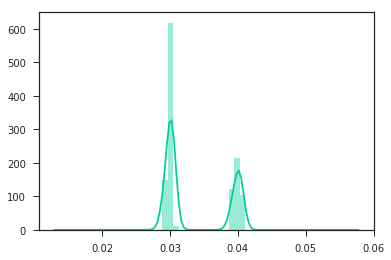

In [19]:
import seaborn as sns

sns.distplot(np.diff(posmat[3]['time']), bins=50)
np.sum(np.diff(posmat[3]['time']) > 0.2)

In [20]:
pos = nel.AnalogSignalArray(posxy, timestamps=postimes, fs=30, merge_sample_gap=0.25)

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:418: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\utils.py:723: UserWarning: some steps in the data are smaller than the requested step size.
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:430: UserWarning: estimated fs and provided fs differ by more than 1%


In [21]:
pos

<AnalogSignalArray at 0x450c3208: 2 signals (17 segments)> for a total of 5:39:25:733 hours

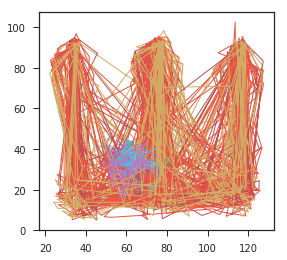

In [22]:
ax = npl.plot2d(pos[session_bounds].simplify(n_points=20000), lw=1)
ax.set_aspect('equal')
#ax.set_ylim(90, 440)
#ax.set_xlim(190, 540)

## Using position data, find bounds of runnning periods

In [23]:
runpos = pos[session_bounds]

sigma_100ms = 0.1
speed2d = nel.utils.ddt_asa(runpos, smooth=True, sigma=sigma_100ms, norm=True) # pixels_per_cm is ~1

In [24]:
run_epochs = nel.utils.get_run_epochs(speed2d.smooth(sigma=0.5), v1=20,v2=10) # original choice

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support


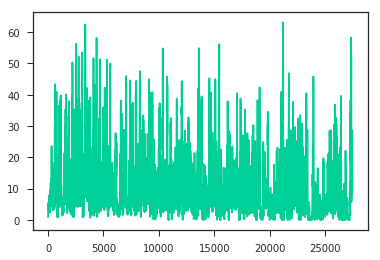

In [25]:
plt.plot(speed2d[session_bounds[1]].ydata.T)

In [26]:
sess0_run = session_bounds[1].intersect(run_epochs)
print(sess0_run)
pos0 = pos[session_bounds[1]]
runpos0 = pos[sess0_run]

<EpochArray at 0x50136fd0: 60 epochs> of length 5:08:432 minutes


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support


In [27]:
sess0_run = session_bounds[1].intersect(run_epochs)
print(sess0_run)
pos0 = pos[session_bounds[1]]
runpos0 = pos[sess0_run]

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support


<EpochArray at 0x5013b438: 60 epochs> of length 5:08:432 minutes


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support


In [28]:
sess7_run = session_bounds[15].intersect(run_epochs)
print(sess7_run)
pos7 = pos[session_bounds[15]]
runpos7 = pos[sess7_run]

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support


<EpochArray at 0x501469e8: 57 epochs> of length 4:56:880 minutes


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support


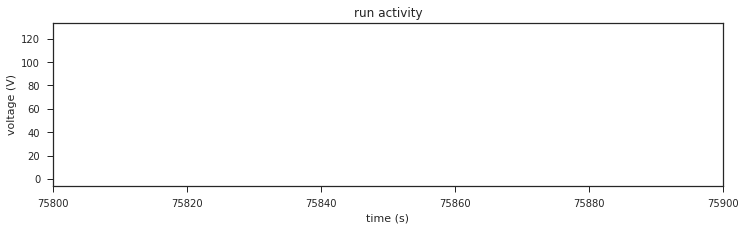

In [29]:
#with npl.FigureManager(show=True, figsize=(64,3)) as (fig, ax):
with npl.FigureManager(show=True, figsize=(12,3)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    plt.plot(pos7.time, pos7.asarray().yvals[0,:], lw=1, color='gray')
    plt.plot(pos7.time, pos7.asarray().yvals[1,:], lw=1, color='gray')
    npl.plot(speed2d[sess7_run], color='green')
    #plt.plot(runpos0.time, runpos0.asarray().yvals[0,:], lw=1, alpha=0.2, color='green')
    #plt.plot(runpos0.time, runpos0.asarray().yvals[1,:], lw=1, alpha=0.2, color='green')
    # npl.plot(pos[sess0_run], ax=ax, lw=1, label='run')
    #ax.set_xlim(5390,5450) # session 0
    ax.set_xlim(75800,75900) # session 0
    plt.title('run activity')

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_analogsignalarray.py:788: UserWarning: ignoring signal outside of support


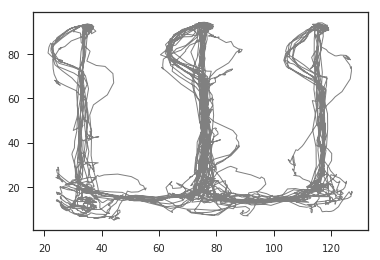

In [32]:
ax = npl.plot2d(pos[session_bounds[15]].simplify(n_points=20000), lw=1, color='gray')
#ax = npl.plot2d(pos[nel.EpochArray([5390,5450])], lw=1)
#ax = npl.plot2d(pos[nel.EpochArray([5420,5450])], lw=1)
#ax = npl.plot2d(pos[nel.EpochArray([75800,75900])], lw=1)
#ax = npl.plot2d(pos[nel.EpochArray([75800,75830])], lw=1)



# Load ripple times to exclude from place cell analysis

In [35]:
mat = scipy.io.loadmat(datadir + 'kl8rippletime01.mat', 
                       struct_as_record=False, squeeze_me=True)

ripmat = np.concatenate([np.vstack((r.starttime, r.endtime)) for r in mat['ripple']],1)
ripples = nel.EpochArray(ripmat.T)
print(ripples)

<EpochArray at 0x1d5a9940: 11,135 epochs> of length 24:01:500 minutes


In [36]:
non_ripples = ripples.complement(session_bounds)
print(non_ripples)

<EpochArray at 0x1d5bb2b0: 11,152 epochs> of length 5:26:02:015 hours


In [37]:
#run_nonripple_epochs = run_epochs.intersect(non_ripples)

In [38]:
#print(run_nonripple_epochs)

In [39]:
st_run = st[run_epochs]

In [40]:
run1 = session_bounds[1].intersect(run_epochs)
run8 = session_bounds[15].intersect(run_epochs)


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:2104: UserWarning: _restrict_to_interval_array() not yet implemented for BinnedTypes
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:384: UserWarning: series tags have not yet been specified


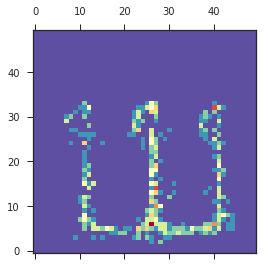

In [41]:
ds_run = 0.5 # 100 ms
ds_50ms = 0.05

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.iloc[run8,hp_pyrs].bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

sigma = 0.2 # smoothing std dev in cm
tc2d = nel.TuningCurve2D(bst=bst_run,
                         extern=pos, 
                         ext_nx=50, 
                         ext_ny=50, 
                         ext_xmin=0, 
                         ext_xmax=140, 
                         ext_ymin=0, 
                         ext_ymax=140, 
                         sigma=sigma, 
                         min_duration=0)

plt.matshow(tc2d.occupancy.T, cmap=plt.cm.Spectral_r)
plt.gca().invert_yaxis()


(<matplotlib.axes._subplots.AxesSubplot at 0x5502e48>,
 <matplotlib.image.AxesImage at 0x54b2588>)

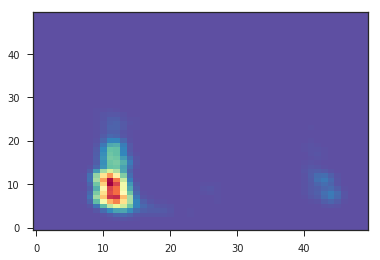

In [42]:
uu=0
uu+=1
npl.imagesc(tc2d.smooth(sigma=3).ratemap[uu,:,:].T, cmap=plt.cm.Spectral_r)

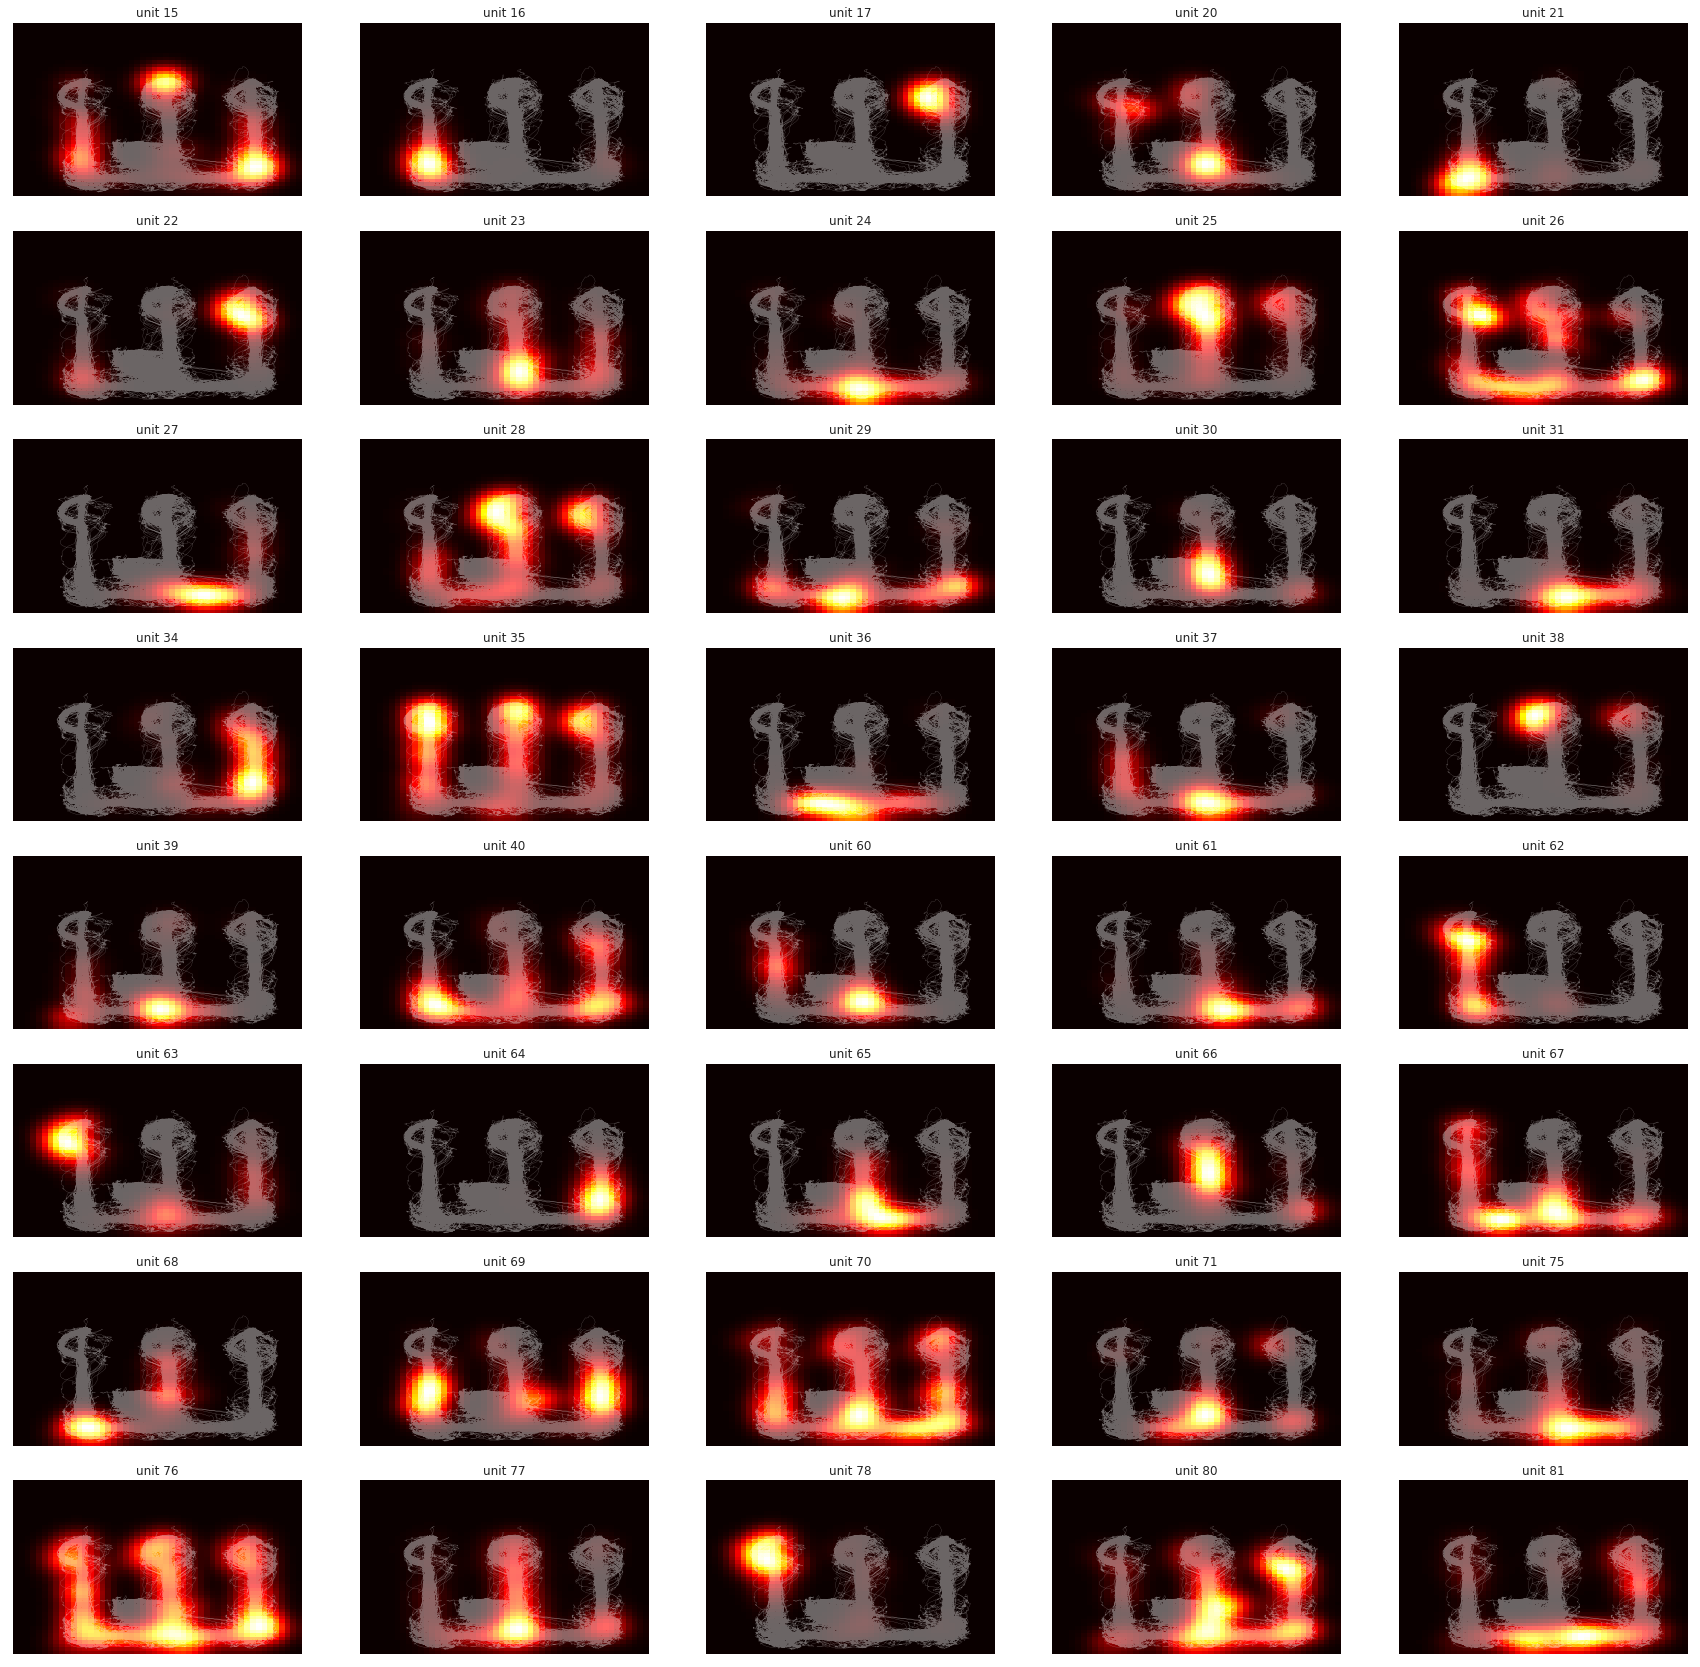

In [43]:
ext_nx=50
ext_ny=50
x0=0; xl=140;
y0=0; yl=140;

xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2
yy_left = np.linspace(y0,yl,ext_ny+1)
yy_mid = np.linspace(y0,yl,ext_ny+1)[:-1]; yy_mid += (yy_mid[1]-yy_mid[0])/2

tvals, vals = pos.asarray()
xvals, yvals = vals

sigma_tc = 7
ratemap = tc2d.smooth(sigma=sigma_tc).ratemap

with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, figsize=(30, 30), nrows=8, ncols=5) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        for ii, ax in enumerate(axes.ravel()):
            placefield = ratemap[ii]
            npl.imagesc(x=xx_mid, y=yy_mid, data=placefield.T, cmap=plt.cm.hot, ax=ax)
            ax.plot(xvals, yvals, lw=0.25, color='w', alpha=0.4)
            ax.set_title('unit {}'.format(tc2d.unit_ids[ii]))
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)

# Let's do some HMMs!

In [44]:

from nelpy import hmmutils
from nelpy.decoding import k_fold_cross_validation
from nelpy.hmmutils import PoissonHMM

import scipy.stats as stats


In [45]:
def prescreen(bst, n_shuffles=1000, num_states=30, k_folds=5, verbose=False):
    
    X = [ii for ii in range(bst.n_epochs)]

    scores_hmm = np.zeros(bst.n_epochs)
    scores_hmm_shuffled = np.zeros((bst.n_epochs, n_shuffles))

    for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):
        if verbose:
            print('  fold {}/{}'.format(kk+1, k_folds))

        SEQs_train = bst[training]
        SEQs_test = bst[validation]

        # train HMM on all training PBEs
        hmm = PoissonHMM(n_components=num_states, verbose=False)
        hmm.fit(SEQs_train)

        # reorder states according to transmat ordering
        transmat_order = hmm.get_state_order('transmat')
        hmm.reorder_states(transmat_order)

        # compute scores_hmm (log likelihoods) of validation set:
        scores_hmm[validation] = hmm.score(SEQs_test)

        for nn in range(n_shuffles):
            if (verbose):
                print(nn, sep=' ', end='')
            # shuffle data coherently within events:
            bst_shuffled = nel.analysis.replay.time_swap_bst(bst)

            SEQs_train = bst_shuffled[training]
            SEQs_test = bst_shuffled[validation]

            # train HMM on shuffled data
            hmm_shuffled = PoissonHMM(n_components=num_states, verbose=False, n_iter=25)
            hmm_shuffled.fit(SEQs_train)

            # score validation set with shuffled-data HMM
            scores_hmm_shuffled[validation, nn] = hmm_shuffled.score(SEQs_test)
            
    return scores_hmm, scores_hmm_shuffled

In [46]:
def compute_session_quality(bst, num_states=30, n_shuffles=200, k_folds=5, verbose=False):
    scores, shuffled = prescreen(bst=bst, 
                                 n_shuffles=n_shuffles, 
                                 num_states=num_states, 
                                 k_folds=k_folds,
                                 verbose=verbose)

    zscore = stats.zmap(scores.mean(), shuffled.mean(axis=0))
    
    
    return zscore, scores, shuffled

In [47]:
ds_run = 0.25 # 100 ms
ds_50ms = 0.05

sigma = 0.3 # 300 ms spike smoothing
st_run_hp = st_run.iloc[:,hp_pyrs]
bst_run1 = st_run_hp[run1].bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)
bst_run8 = st_run_hp[run8].bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:2104: UserWarning: _restrict_to_interval_array() not yet implemented for BinnedTypes
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:2104: UserWarning: _restrict_to_interval_array() not yet implemented for BinnedTypes


In [48]:
hmm = nel.hmmutils.PoissonHMM(n_components=30, verbose=True, n_iter=20, random_state=0)
hmm.fit(bst_run1)


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: divide by zero encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: invalid value encountered in log
         2      -20623.5386       +3431.3698
         3      -20276.8721        +346.6665
         4      -20199.3598         +77.5124
         5      -20176.8728         +22.4870
         6      -20160.7932         +16.0796
         7      -20143.1554         +17.6378
         8      -20136.2979          +6.8575
         9      -20134.0652          +2.2327
        10      -20127.5494          +6.5158
        11      -20119.4386          +8.1107
        12      -20113.9409          +5.4977
        13      -20101.2213         +12.7196
        14      -20097.2351          +3.9862
        15      -20092.0839          +5.1513
        16      -20

nelpy.PoissonHMM(init_params='stm', n_components=30, n_iter=20, params='stm',
      random_state=0, verbose=True); fit=True, fit_ext=False

In [49]:
if 0:
    zscore0,_,_ = compute_session_quality(bst_run1, num_states=30, n_shuffles=100, verbose=True)

  fold 1/5


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: divide by zero encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: invalid value encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:384: UserWarning: series tags have not yet been specified


0

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: divide by zero encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: invalid value encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:384: UserWarning: series tags have not yet been specified


1

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: divide by zero encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: invalid value encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:384: UserWarning: series tags have not yet been specified


2

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: divide by zero encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: invalid value encountered in log


KeyboardInterrupt: 

In [50]:
st_SWR = st[ripples]

In [51]:
bst_run1_SWR = st_SWR.iloc[session_bounds[1],hp_pyrs].bin(ds=0.015)
bst_run8_SWR = st_SWR.iloc[session_bounds[15],hp_pyrs].bin(ds=0.015)


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:2104: UserWarning: _restrict_to_interval_array() not yet implemented for Bin

In [52]:
run1_SWR_hmm = nel.hmmutils.PoissonHMM(n_components=30, verbose=False, n_iter=25, random_state=0)
run8_SWR_hmm = nel.hmmutils.PoissonHMM(n_components=30, verbose=False, n_iter=25, random_state=0)

run1_SWR_hmm.fit(bst_run1_SWR)
run8_SWR_hmm.fit(bst_run8_SWR)

neworder = run1_SWR_hmm.get_state_order()
run1_SWR_hmm.reorder_states(neworder)

neworder = run8_SWR_hmm.get_state_order()
run8_SWR_hmm.reorder_states(neworder)



C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: divide by zero encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\hmmlearn-0.2.0-py3.6-win-amd64.egg\hmmlearn\utils.py:113: RuntimeWarning: invalid value encountered in log
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:384: UserWarning: series tags have not yet been specified
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:384: UserWarning: series tags have not yet been specified


In [53]:
def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols


def get_vtc2d(hmm, bst, pos, nx=20, ny=20, normalize=True, normalize_by_occupancy=True):
    
    num_states = hmm.n_components
    xpos, ypos = pos.asarray(at=bst.centers).yvals
    
    ext_xmin, ext_xmax = np.floor(pos[:,0].min()/10)*10-1, np.ceil(pos[:,0].max()/10)*10+1
    ext_ymin, ext_ymax = np.floor(pos[:,1].min()/10)*10-1, np.ceil(pos[:,1].max()/10)*10+1
    
    xx_left = np.linspace(ext_xmin, ext_xmax, nx+1)
    xx_mid = np.linspace(ext_xmin, ext_xmax, nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2
    yy_left = np.linspace(ext_ymin, ext_ymax, ny+1)
    yy_mid = np.linspace(ext_ymin, ext_ymax, ny+1)[:-1]; yy_mid += (yy_mid[1]-yy_mid[0])/2

    ext_y = np.digitize(ypos, yy_left) - 1 # spatial bin numbers
    ext_x = np.digitize(xpos, xx_left) - 1

    t = np.zeros(len(xpos), dtype=np.float)

    for ii, (x, y) in enumerate(zip(ext_x, ext_y)):
        t[ii] = sub2ind((nx, ny), x, y)

    t[t==0] = np.nan
    t[t>=nx*ny] = np.nan
    
    extern = hmm.fit_ext(X=bst, ext=t, n_extern=nx*ny, normalize=normalize, 
                         normalize_by_occupancy=normalize_by_occupancy)
    
    # transform into ratemap shape
    tmp = np.reshape(extern, (num_states, nx, ny))
    vtc_ratemap = np.transpose(tmp, (0,2,1)) # for images, we have (y,x) <==> (r,c) coordinates

    vtc2d = nel.TuningCurve2D(ratemap=vtc_ratemap, min_duration=0, 
                              ext_xmin=ext_xmin, ext_xmax=ext_xmax, ext_ymin=ext_ymin, ext_ymax=ext_ymax)
    
#     vtc2d = vtc2d.smooth(sigma=sigma_tc)
    vtc2d._initialize_mask_from_extern(pos)
    
    return vtc2d    


In [54]:
normalize=False
normalize_by_occupancy=True

sigma_spk = 0.3 # 300 ms spike smoothing
ds_25ms = 0.025
nx = 30
ny = 30


    
lsPFr1_E1 = get_vtc2d(hmm=run1_SWR_hmm, bst=bst_run1, pos=pos, normalize=normalize, 
                      nx=nx, ny=ny, normalize_by_occupancy=normalize_by_occupancy)
lsPFr1_E8 = get_vtc2d(hmm=run1_SWR_hmm, bst=bst_run8, pos=pos, normalize=normalize, 
                      nx=nx, ny=ny, normalize_by_occupancy=normalize_by_occupancy)

lsPFr8_E1 = get_vtc2d(hmm=run8_SWR_hmm, bst=bst_run1, pos=pos, normalize=normalize, 
                      nx=nx, ny=ny, normalize_by_occupancy=normalize_by_occupancy)
lsPFr8_E8 = get_vtc2d(hmm=run8_SWR_hmm, bst=bst_run8, pos=pos, normalize=normalize, 
                      nx=nx, ny=ny, normalize_by_occupancy=normalize_by_occupancy)

#     data[animal][day]['VTC_E1'] = vtc2d 
#     data[animal][day]['VTC_E2'] = vtc2d

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\auxiliary\_tuningcurve.py:609: RuntimeWarning: invalid value encountered in true_divide


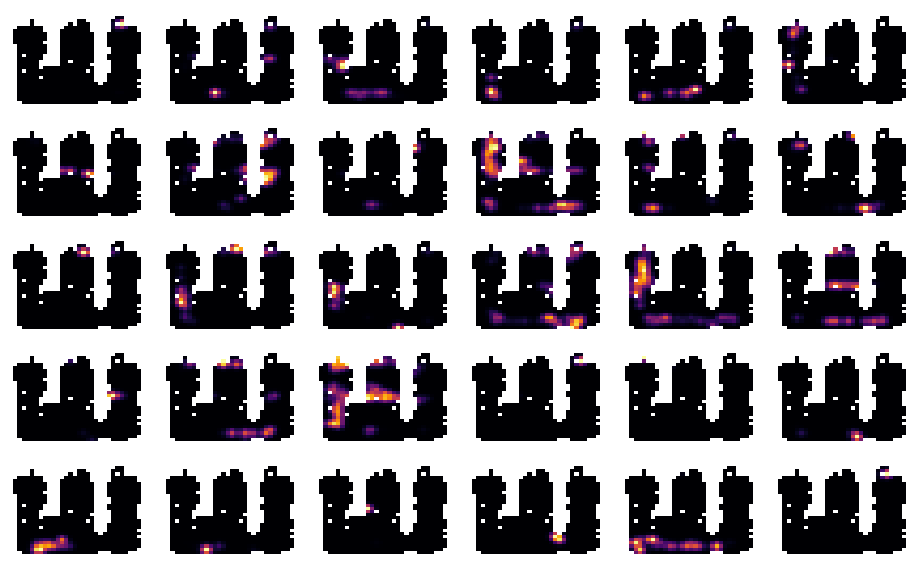

In [55]:
sigma_tc=3

def plot_all_VTCs_2D(vtc, sigma_tc):
    ax_rows = 5
    ax_cols = 6
    n_axes = ax_rows * ax_cols
    
    n_units = vtc.n_units
    
    assert n_axes >= n_units, 'not enough axes for all units!'
    
    fig, axes = plt.subplots(ax_rows, ax_cols, figsize=(16, 10))
    for unit, ax in enumerate(axes.ravel()[:n_units]):
        pass
        npl.utils.clear_left_right(ax)
        npl.utils.clear_top_bottom(ax)
        _, img = npl.imagesc(vtc.smooth(sigma=sigma_tc).ratemap[unit,:,:].T, cmap=plt.cm.inferno, ax=ax)            
    
plot_all_VTCs_2D(vtc=lsPFr1_E8,
                    sigma_tc=sigma_tc)

# npl.savefig('lspf-local-small')

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\auxiliary\_tuningcurve.py:609: RuntimeWarning: invalid value encountered in true_divide


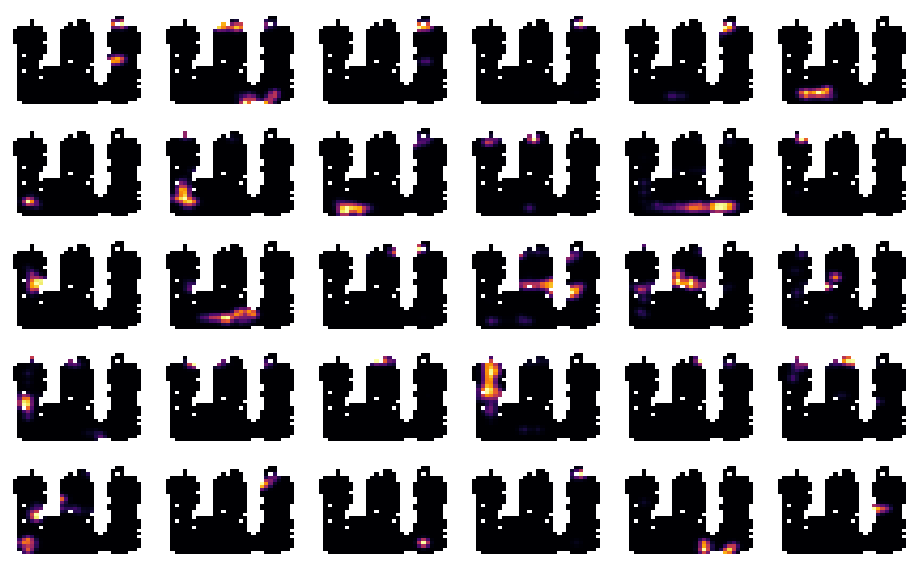

In [56]:
plot_all_VTCs_2D(vtc=lsPFr8_E8,
                    sigma_tc=sigma_tc)


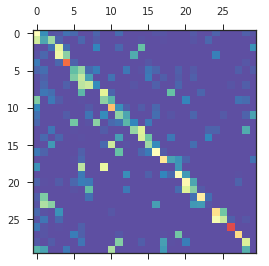

In [57]:
plt.matshow(run1_SWR_hmm.transmat, cmap=plt.cm.Spectral_r, vmin=0, vmax=1)

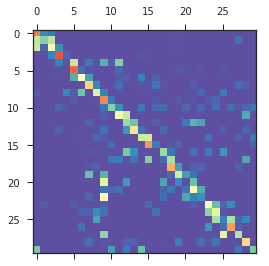

In [58]:
plt.matshow(run8_SWR_hmm.transmat, cmap=plt.cm.Spectral_r, vmin=0, vmax=1)

In [59]:
posteriors88 = run8_SWR_hmm.predict_proba(X=bst_run8)
posteriors18 = run1_SWR_hmm.predict_proba(X=bst_run8)
posteriors81 = run8_SWR_hmm.predict_proba(X=bst_run1)
posteriors11 = run1_SWR_hmm.predict_proba(X=bst_run1)

In [60]:
from scipy.linalg import orthogonal_procrustes

R, scale = orthogonal_procrustes(posteriors18.T,posteriors88.T)

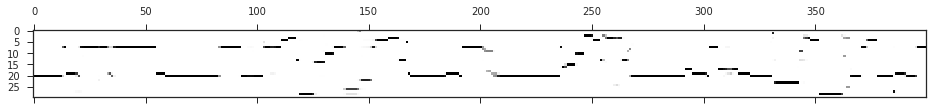

In [61]:
plt.matshow(posteriors11[:,:400])

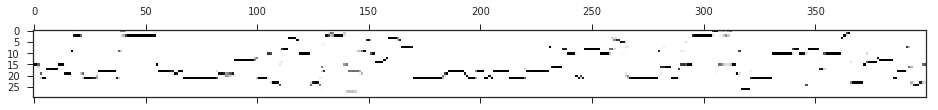

In [62]:
plt.matshow(posteriors81[:,:400])

In [63]:
logprob88, _, _ = run8_SWR_hmm.decode(X=bst_run8)
logprob18, _, _ = run1_SWR_hmm.decode(X=bst_run8)
logprob81, _, _ = run8_SWR_hmm.decode(X=bst_run1)
logprob11, _, _ = run1_SWR_hmm.decode(X=bst_run1)

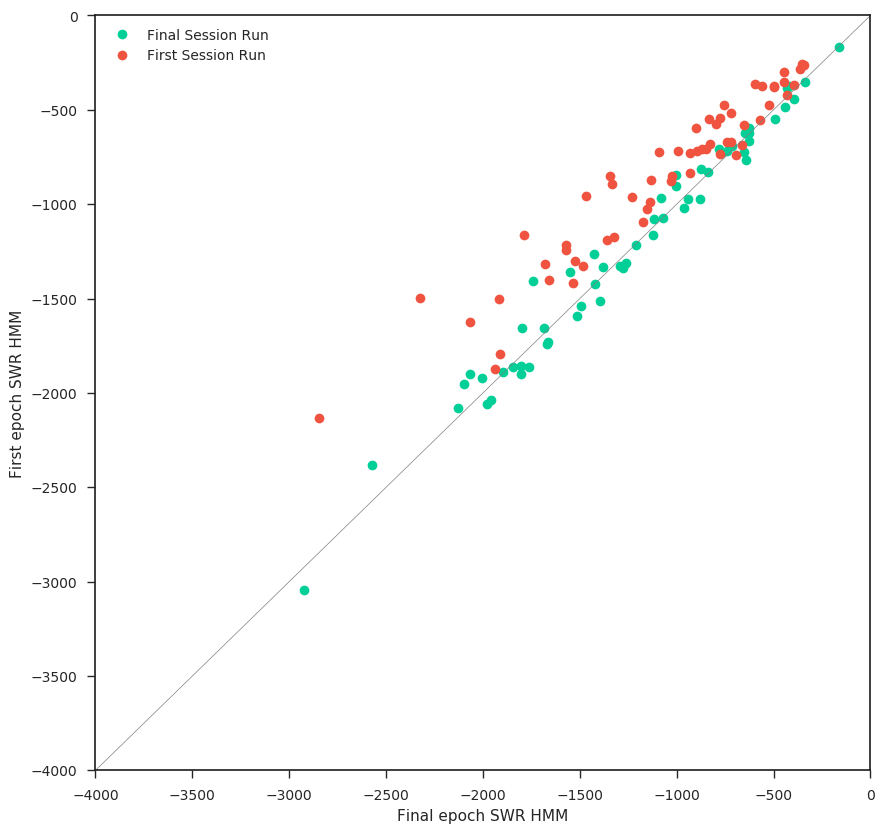

In [64]:
with npl.FigureManager(show=True, figsize=(10, 10), dpi=100, nrows=1, ncols=1) as (fig, ax):
    ax.plot(logprob88,logprob18,'o')
    ax.plot(logprob81,logprob11,'o')
    ax.plot([-4000,0],[-4000,0], lw=0.5, color='grey')
    ax.set_xlim(-4000,0)
    ax.set_ylim(-4000,0)
    ax.set_xlabel('Final epoch SWR HMM')
    ax.set_ylabel('First epoch SWR HMM')
    ax.legend(['Final Session Run','First Session Run'])

In [65]:
eps = [1,15]
train_idx = []
test_idx = []
logprobs = []
k_folds = 5
for ep in eps:
    bst_ = st_SWR.iloc[session_bounds[ep],hp_pyrs].bin(ds=0.015)
    X = [ii for ii in range(bst_.n_epochs)]

    train_idx.append([])
    test_idx.append([])
    logprobs.append([])
    for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):
        train_idx[-1].append(training)
        test_idx[-1].append(validation)

        swr_hmm = nel.hmmutils.PoissonHMM(n_components=30, verbose=False, n_iter=25, random_state=0)
        swr_hmm.fit(bst_[training])
        logprob, _, _ = swr_hmm.decode(X=bst_[validation])
        logprobs[-1].append(logprob)



C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:2104: UserWarning: _restrict_to_interval_array() not yet implemented for Bin

In [66]:
sorted_logprobs = []
for e, ep in enumerate(eps):
    all_test_idx = np.concatenate(test_idx[e])
    sorting_indices = all_test_idx.argsort()
    all_logprobs = np.concatenate(logprobs[e])
    sorted_logprobs.append(all_logprobs[sorting_indices])


In [67]:
sorted_logprobs

[array([ -32.89882292,  -55.28104124,  -10.46227161,  -26.11412491,
         -15.24114333,  -16.85325199,  -12.52330886,  -23.17203849,
         -85.61248858,  -19.58054252,  -21.17697937,  -27.38394955,
         -39.52963721,  -12.4042615 ,  -35.79325765,  -14.5059944 ,
         -66.48051828,  -53.02327046,   -8.0556262 ,  -18.9565761 ,
         -33.57540312,  -50.78136279,  -67.88556819,  -28.10814705,
         -47.25272047,  -49.40768791,  -33.08146499,  -54.61076012,
         -39.80129813,  -34.54665649,  -12.34357715,  -39.23693551,
         -14.04798488,  -27.46018914,  -59.62718098,  -40.26847906,
         -39.60532416,  -35.44739834,  -49.39504803,  -72.71351409,
         -33.28039465,  -17.50352779,  -17.75129228,  -34.58199418,
          -9.68915325,  -27.96817563,  -15.26862796,  -32.64095287,
         -20.37001254,  -33.509509  ,  -18.76225365,  -23.18722654,
         -22.71873788,  -36.5006857 ,  -26.61590629,  -15.83032719,
         -27.73202362,  -12.14753794,  -12.63848

In [68]:
# run0_SWR_hmm.fit(bst_run0_SWR)
# run7_SWR_hmm.fit(bst_run7_SWR)

logprob_SWR_81, _, _ = run8_SWR_hmm.decode(X=bst_run1_SWR)
logprob_SWR_18, _, _ = run1_SWR_hmm.decode(X=bst_run8_SWR)
logprob_SWR_11 = sorted_logprobs[0]
logprob_SWR_88 = sorted_logprobs[1]

print(len(logprob_SWR_81), len(logprob_SWR_18))
print(len(logprob_SWR_11), len(logprob_SWR_88))

337 295
337 295


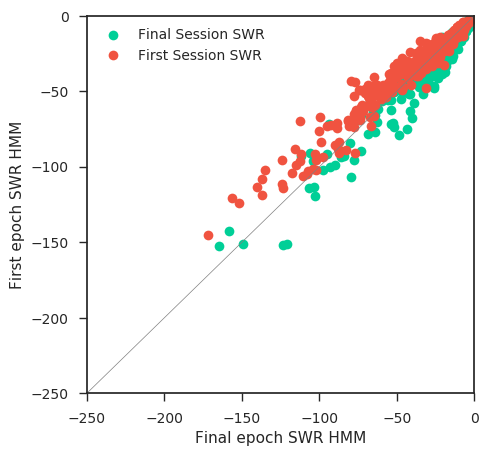

In [69]:
with npl.FigureManager(show=True, figsize=(5, 5), dpi=100, nrows=1, ncols=1) as (fig, ax):
    ax.plot(logprob_SWR_88,logprob_SWR_18,'o')
    ax.plot(logprob_SWR_81,logprob_SWR_11,'o')
    ax.plot([-250,0],[-250,0], lw=0.5, color='grey')
    ax.set_xlim(-250,0)
    ax.set_ylim(-250,0)
    ax.set_xlabel('Final epoch SWR HMM')
    ax.set_ylabel('First epoch SWR HMM')
    ax.legend(['Final Session SWR','First Session SWR'])

In [70]:
Almost_All_SWR_HMM = nel.hmmutils.PoissonHMM(n_components=30, verbose=False, n_iter=25, random_state=0)
bst_Almost_ALL_SWR = st_SWR.iloc[session_bounds[3:15:2],hp_pyrs].bin(ds=0.015)
Almost_All_SWR_HMM.fit(bst_Almost_ALL_SWR)

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:1687: UserWarning: interval duration is less than bin size: ignoring...
C:\U

nelpy.PoissonHMM(init_params='stm', n_components=30, n_iter=25, params='stm',
      random_state=0, verbose=False); fit=True, fit_ext=False

In [71]:
order = Almost_All_SWR_HMM.get_state_order()
Almost_All_SWR_HMM.reorder_states(order)

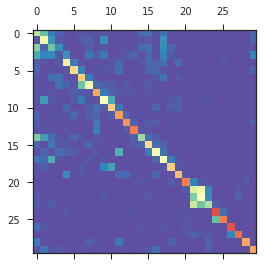

In [72]:
plt.matshow(Almost_All_SWR_HMM.transmat, cmap=plt.cm.Spectral_r, vmin=0, vmax=1)

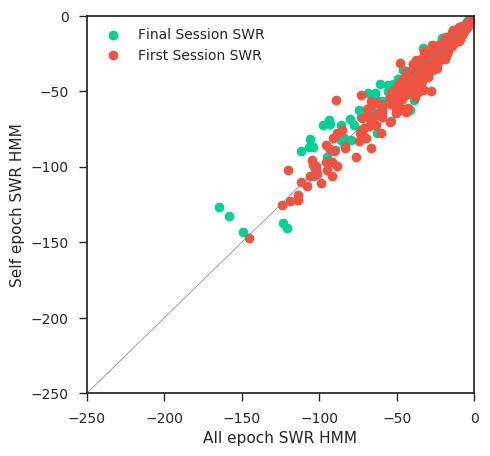

In [73]:
logprob_SWR_A1, _, _ = Almost_All_SWR_HMM.decode(X=bst_run1_SWR)
logprob_SWR_A8, _, _ = Almost_All_SWR_HMM.decode(X=bst_run8_SWR)


with npl.FigureManager(show=True, figsize=(5, 5), dpi=100, nrows=1, ncols=1) as (fig, ax):
    ax.plot(logprob_SWR_88,logprob_SWR_A8,'o')
    ax.plot(logprob_SWR_11,logprob_SWR_A1,'o')
    ax.plot([-250,0],[-250,0], lw=0.5, color='grey')
    ax.set_xlim(-250,0)
    ax.set_ylim(-250,0)
    ax.set_xlabel('All epoch SWR HMM')
    ax.set_ylabel('Self epoch SWR HMM')
    ax.legend(['Final Session SWR','First Session SWR'])

In [74]:
normalize=False
normalize_by_occupancy=True

sigma_spk = 0.3 # 300 ms spike smoothing
ds_25ms = 0.025
nx = 30
ny = 30


    
lsPFAll_E1 = get_vtc2d(hmm=Almost_All_SWR_HMM, bst=bst_run1, pos=pos, normalize=normalize, 
                      nx=nx, ny=ny, normalize_by_occupancy=normalize_by_occupancy)
lsPFAll_E8 = get_vtc2d(hmm=Almost_All_SWR_HMM, bst=bst_run8, pos=pos, normalize=normalize, 
                      nx=nx, ny=ny, normalize_by_occupancy=normalize_by_occupancy)


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\auxiliary\_tuningcurve.py:609: RuntimeWarning: invalid value encountered in true_divide


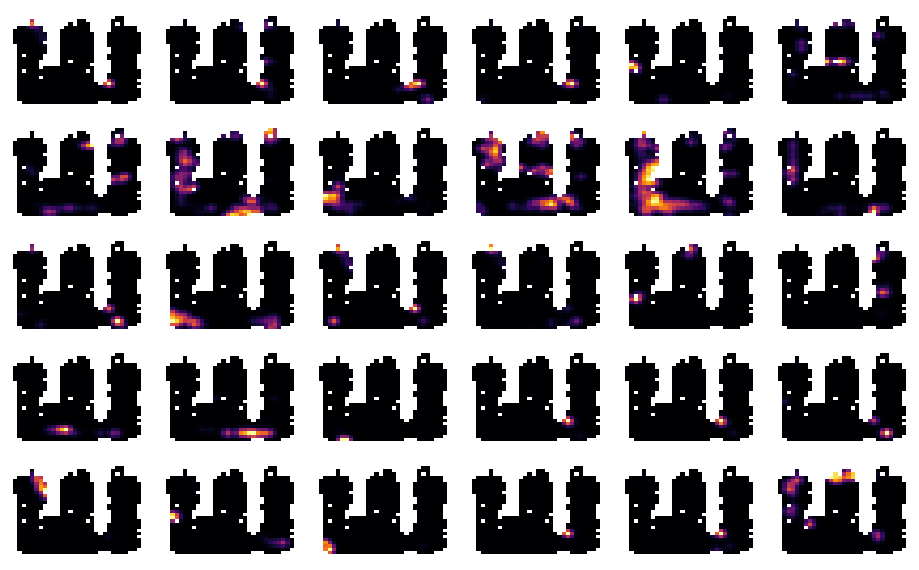

In [75]:
plot_all_VTCs_2D(vtc=lsPFAll_E1,
                    sigma_tc=sigma_tc)

C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\auxiliary\_tuningcurve.py:609: RuntimeWarning: invalid value encountered in true_divide


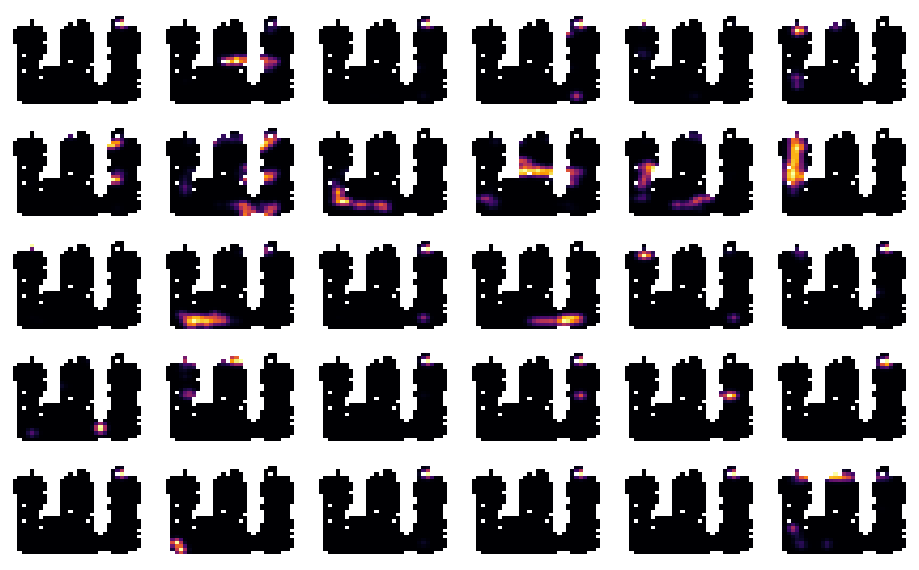

In [76]:
plot_all_VTCs_2D(vtc=lsPFAll_E8,
                    sigma_tc=sigma_tc)

In [77]:
len(ctx_cells), len(hp_pyrs)

(30, 48)

In [78]:
ds_run = 0.25 # 100 ms
ds_50ms = 0.05

sigma = 0.3 # 300 ms spike smoothing
st_run_ctx = st_run.iloc[:,ctx_cells]
bst_run1_ctx = st_run_ctx[run1].bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)
bst_run8_ctx = st_run_ctx[run8].bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)


C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:2104: UserWarning: _restrict_to_interval_array() not yet implemented for BinnedTypes
C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\core\_eventarray.py:2104: UserWarning: _restrict_to_interval_array() not yet implemented for BinnedTypes


In [79]:
posteriorsA1  = Almost_All_SWR_HMM.predict_proba(X=bst_run1)
posteriorsA8  = Almost_All_SWR_HMM.predict_proba(X=bst_run8)



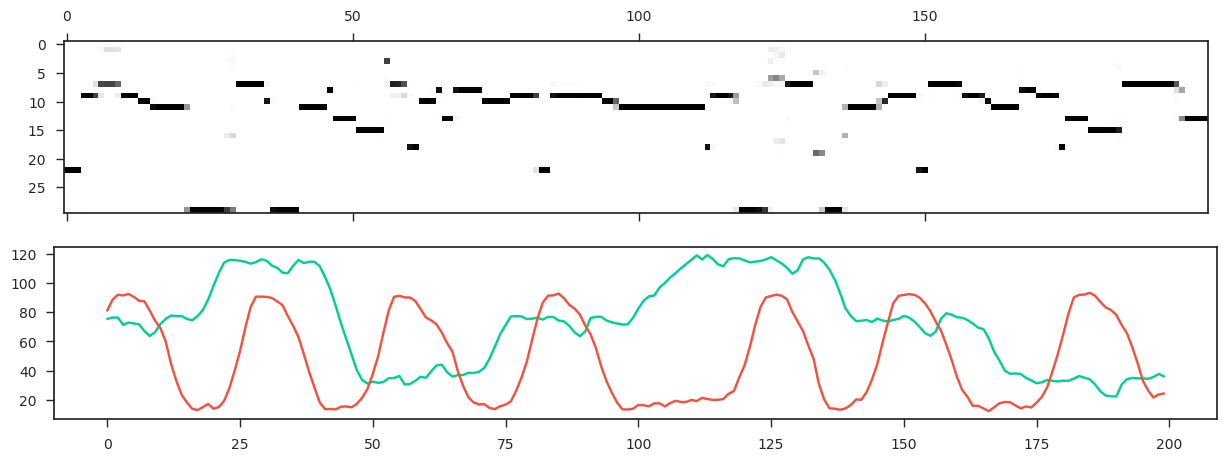

In [80]:

t, run8_pos = pos.asarray(at=bst_run8.bin_centers)

tmax = 200
with npl.FigureManager(show=True, figsize=(15, 5), dpi=100, nrows=2, ncols=1) as (fig, axes):
    (ax0, ax1) = axes
    ax0.matshow(posteriorsA8[:,:tmax])
    #ax, img = npl.imagesc(x=bst_snippet.bin_centers, y=np.linspace(0,310, num=30), data=posterior)
    ax1.plot(run8_pos[:,:tmax].T)

    

In [81]:
PFC_MeanA1 = posteriorsA1.dot(bst_run1_ctx.data.T) / posteriorsA1.sum(axis=1, keepdims=True)
PFC_MeanA8 = posteriorsA8.dot(bst_run8_ctx.data.T) / posteriorsA8.sum(axis=1, keepdims=True)


(<matplotlib.axes._subplots.AxesSubplot at 0x6eb9f710>,
 <matplotlib.image.AxesImage at 0x34c2c0f0>)

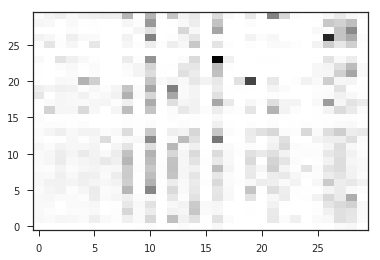

In [82]:
npl.imagesc(PFC_MeanA1)

(<matplotlib.axes._subplots.AxesSubplot at 0x2c65ebe0>,
 <matplotlib.image.AxesImage at 0x1d5500b8>)

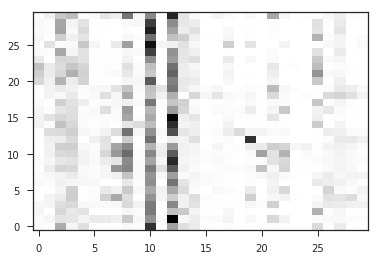

In [83]:
npl.imagesc(PFC_MeanA8)

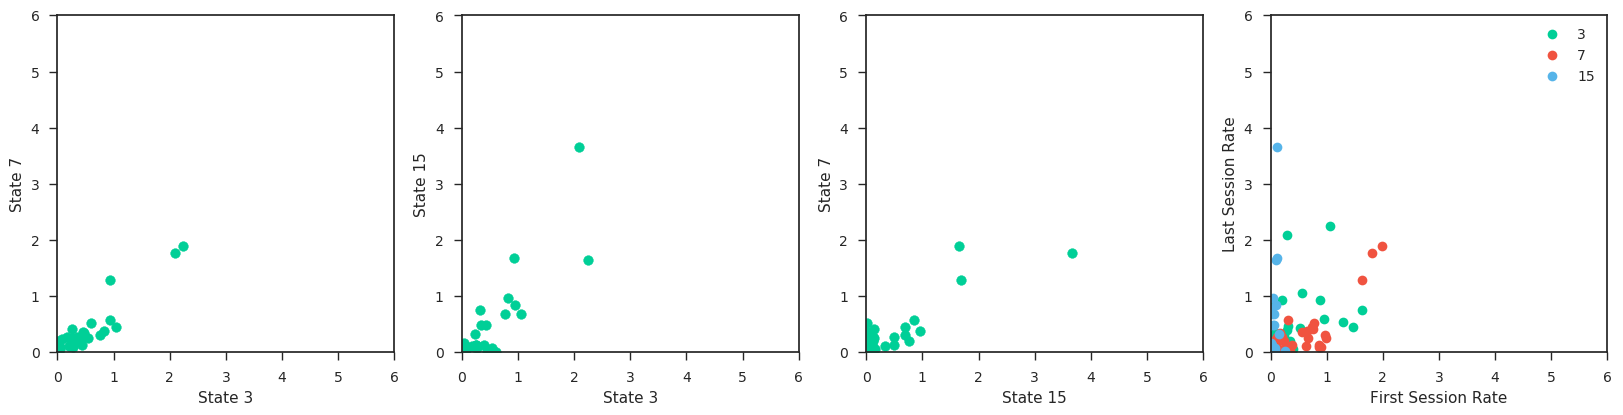

In [84]:
states_to_plot = [24, 29, 25] # [similar, similar, different]

states_to_plot = [3, 7, 15] # [similar, similar, different]
with npl.FigureManager(show=True, figsize=(20, 5), dpi=100, nrows=1, ncols=4) as (fig, axes):
    (ax0, ax1, ax2, ax3) = axes

    ax0.scatter(PFC_MeanA8[states_to_plot[0],:], PFC_MeanA8[states_to_plot[1],:])
    ax0.set_xlabel('State ' + str(states_to_plot[0]))
    ax0.set_ylabel('State ' + str(states_to_plot[1]))

    ax1.scatter(PFC_MeanA8[states_to_plot[0],:], PFC_MeanA8[states_to_plot[2],:])
    ax1.set_xlabel('State ' + str(states_to_plot[0]))
    ax1.set_ylabel('State ' + str(states_to_plot[2]))
    
    ax2.scatter(PFC_MeanA8[states_to_plot[2],:], PFC_MeanA8[states_to_plot[1],:])
    ax2.set_xlabel('State ' + str(states_to_plot[2]))
    ax2.set_ylabel('State ' + str(states_to_plot[1]))

    
    ax3.plot(PFC_MeanA1[states_to_plot[0],:], PFC_MeanA8[states_to_plot[0],:], 'o')
    ax3.plot(PFC_MeanA1[states_to_plot[1],:], PFC_MeanA8[states_to_plot[1],:], 'o')
    ax3.plot(PFC_MeanA1[states_to_plot[2],:], PFC_MeanA8[states_to_plot[2],:], 'o')
    ax3.set_xlabel('First Session Rate')
    ax3.set_ylabel('Last Session Rate')
    ax3.legend([str(states_to_plot[0]),str(states_to_plot[1]),str(states_to_plot[2])])

    for ax in axes:
        ax.set_xlim(0,6)
        ax.set_ylim(0,6)
        ax.set_aspect('equal')
    



C:\Users\jdshin\AppData\Local\Continuum\anaconda3\lib\site-packages\nelpy\auxiliary\_tuningcurve.py:609: RuntimeWarning: invalid value encountered in true_divide


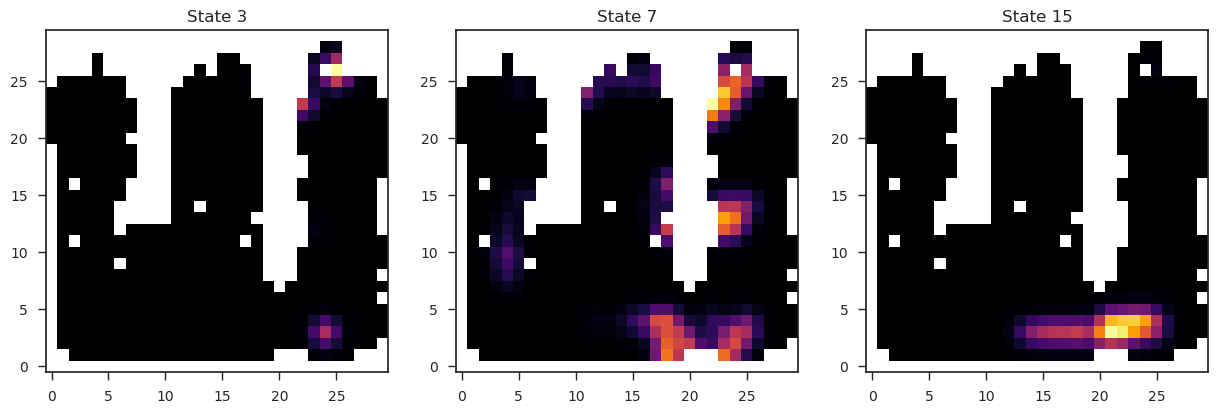

In [85]:
with npl.FigureManager(show=True, figsize=(15, 5), dpi=100, nrows=1, ncols=3) as (fig, axes):
    for i, ax in enumerate(axes):
        uu = states_to_plot[i]
        _, img = npl.imagesc(lsPFAll_E8.smooth(sigma=sigma_tc).ratemap[uu,:,:].T, cmap=plt.cm.inferno, ax=ax)            
        ax.set_aspect('equal')
        ax.set_title('State {}'.format(uu))
        
